# 目的
最適な特徴量をピックアップする

In [1]:
## Requirement
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
import xgboost as xgb
import lightgbm as lgb
import sklearn.preprocessing as sp
from sklearn.preprocessing import StandardScaler


def meanAbsoluteError(y_test, y_pred):
    loss = 0
    for i in range(len(y_test)):
        loss += abs(y_test[i] - y_pred[i])
    loss /= len(y_test)
    return loss

In [2]:
_df_train= pd.read_csv("./dataset/pubg-train.csv")
_df_test = pd.read_csv("./dataset/pubg-test.csv")

In [23]:
_df_train.dtypes

Id                  object
groupId             object
matchId             object
assists              int64
boosts               int64
damageDealt        float64
DBNOs                int64
headshotKills        int64
heals                int64
killPlace            int64
killPoints           int64
kills                int64
killStreaks          int64
longestKill        float64
matchDuration        int64
matchType           object
numGroups            int64
rankPoints           int64
revives              int64
rideDistance       float64
roadKills            int64
swimDistance       float64
teamKills            int64
vehicleDestroys      int64
walkDistance       float64
weaponsAcquired      int64
winPoints            int64
winPlacePerc       float64
dtype: object

In [53]:
group2count = _df_train["groupId"].value_counts().to_dict()
group2count

{'14d6b54cdec6bc': 58,
 '128b07271aa012': 47,
 '1146732e6a3ea9': 21,
 '144f98129b9d57': 19,
 '0f1c0291af456b': 18,
 '00f5960c4e34d0': 17,
 '0d0b3725871a42': 17,
 '02feac7e6be616': 17,
 '0af168ce9f9ba1': 17,
 '0c0753e7c8d06e': 16,
 '0706483513d5a9': 16,
 '0e217312528ec9': 16,
 '17e3c122dada43': 16,
 '0c205074ea3557': 16,
 '10af5b3fa11740': 16,
 '0e120a8d2f6105': 16,
 '11d0b485c3912e': 15,
 '09f741a48002a5': 15,
 '1652ec076a1b0e': 15,
 '0e05e03bfa691a': 15,
 '09ce3cc732ec58': 15,
 '15953883553e07': 15,
 '0470b782aed4ad': 15,
 '16a10031f53382': 15,
 '14987ff1b83ec3': 15,
 '068c54c9fb82bc': 15,
 '14e0ffc5adb856': 15,
 '04137a062f2008': 15,
 '05a1b5aa08f77f': 14,
 '082510b8b457ca': 14,
 '16e3effdf983d7': 14,
 '165d0bca12a844': 14,
 '0a9a4477ad0da4': 14,
 '0746344a018526': 14,
 '039233e3876bf1': 14,
 '19292842fcd582': 14,
 '138cdeff3a66a5': 14,
 '13fe42d7682af9': 14,
 '00541c7636e037': 14,
 '016a5af0b8ab5a': 14,
 '17f66e13fde20e': 14,
 '1327f1ad03ee1e': 14,
 '04b6df634ec7a2': 14,
 '098f63b24

In [50]:
_df_train["matchId"].to_csv("matchId2num.csv", index=False)

In [6]:
def drop_and_add(df):
    ep = 0.00001
    df = df.drop(columns=["Id"])
    """
    df['_killPoints_rankpoints'] = df['rankPoints']+df['killPoints']
    df["_totalDistance"] = 0.25*df["rideDistance"]+df["walkDistance"]+df["swimDistance"]
    df['_walkDistance_heals_Ratio'] = df['walkDistance'] / df['heals']
    df['_walkDistance_kills_Ratio'] = df['walkDistance'] / df['kills']
    df['_kills_walkDistance_Ratio'] = df['kills'] / df['walkDistance']
    df['_totalDistancePerDuration'] =  df["_totalDistance"]/df["matchDuration"]
    df['_killPlace_kills_Ratio'] = df['killPlace']/df['kills']
    df['_walkDistancePerDuration'] =  df["walkDistance"]/df["matchDuration"]
    df['walkDistancePerc'] = df.groupby('matchId')['walkDistance'].rank(pct=True).values
    df['killPerc'] = df.groupby('matchId')['kills'].rank(pct=True).values
    df['killPlacePerc'] = df.groupby('matchId')['killPlace'].rank(pct=True).values
    df['weaponsAcquired'] = df.groupby('matchId')['weaponsAcquired'].rank(pct=True).values
    df['_walkDistance_kills_Ratio2'] = df['walkDistancePerc'] / df['killPerc']
    df['_kill_kills_Ratio2'] = df['killPerc']/df['walkDistancePerc']
    df['_killPlace_walkDistance_Ratio2'] = df['walkDistancePerc']/df['killPlacePerc']
    df['_killPlace_kills_Ratio2'] = df['killPlacePerc']/df['killPerc']
    df['_totalDistance'] = df.groupby('matchId')['_totalDistance'].rank(pct=True).values
    df['_walkDistance_kills_Ratio3'] = df['walkDistancePerc'] / df['kills']
    df['_walkDistance_kills_Ratio4'] = df['kills'] / df['walkDistancePerc']
    df['_walkDistance_kills_Ratio5'] = df['killPerc'] / df['walkDistance']
    df['_walkDistance_kills_Ratio6'] = df['walkDistance'] / df['killPerc']
    df.loc[df["rankPoints"]==-1, "rankPoints"] =0
    df["headshot_ratio"] = df["headshotKills"]/df["kills"]
    df["kills_over_headshotkills"] = df["kills"]/df["headshotKills"]
    df["killstreak_ratio"] = df["killStreaks"]/df["kills"]
    df["killPlace_ratio"] = df["killPlace"]/df["kills"]
    df["rank_kill_points"] = df["rankPoints"]+df["killPoints"]
    df["weaponAcquired_per_distance"] = df["_totalDistance"]/df["weaponsAcquired"]
    df["kill_assists"] = df["kills"]+df["assists"]
    df["assist_rate"] = df["assists"]/df["kill_assists"]
    df["healboosts"] = df["heals"]+df["boosts"]
    df['walkDistance_over_heals'] = df['walkDistance'] / df['heals']
    df['walkDistance_over_kills'] = df['walkDistance'] / df['kills']
    df['killsPerWalkDistance'] = df['kills'] / df['walkDistance']
    df["skill"] = df["headshotKills"] + df["roadKills"]
    df["killPlace"] = -df["killPlace"]
    """
    df = df.drop(columns="groupId")
    
    df[df == np.Inf] = np.NaN
    df[df == np.NINF] = np.NaN
    df.fillna(0, inplace=True)
    """
    #カテゴリラベルをone-hot化
    le = sp.LabelEncoder()
    le.fit(df["matchType"].unique())
    df["matchType"] = le.fit_transform(df["matchType"])
    ohe = sp.OneHotEncoder()
    enced = ohe.fit_transform(df["matchType"].values.reshape(1, -1).transpose())
    temp = pd.DataFrame(index=df["matchType"].index, columns="matchType-" + le.classes_, data=enced.toarray())
    df = pd.concat([df, temp], axis=1)
    """
    df = df.drop(columns=["matchType"])
    return df

In [7]:
df = drop_and_add(_df_train)
df_test = drop_and_add(_df_test)

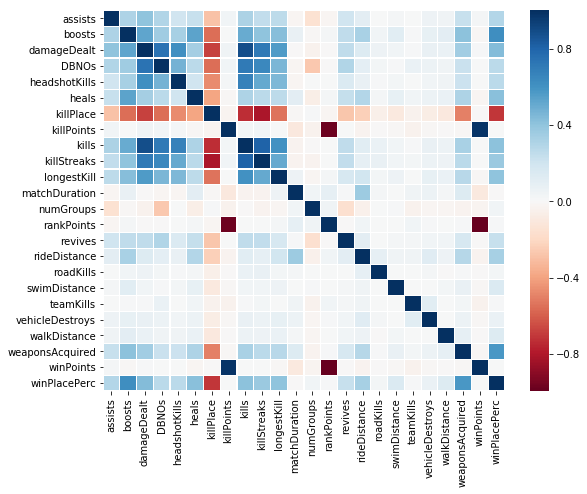

In [8]:
df = drop_and_add(_df_train)
cols_to_drop = ['Id', 'groupId', 'matchId', 'matchType']
cols_to_drop_from_mp = ["killPoints", "rankPoints"]
#cols_to_drop.extend(cols_to_drop_from_mp)
cols_to_fit = [col for col in df.columns if col not in cols_to_drop]
corr = df[cols_to_fit].corr()

target = "winPlacePerc"
Y = df[target]
X = df.drop(columns=target)

plt.figure(figsize=(9,7))
sns.heatmap(
    corr,
    xticklabels = corr.columns.values,
    yticklabels = corr.columns.values,
    linecolor='white',
    linewidths=0.1,
    cmap="RdBu"    #heatmapの種類
)
 
plt.show()

In [46]:
def get_more_features(df_fit,df_test, num=200, target="winPlacePerc"):
    df = df_fit.drop(columns=target)
    corr = df.corr()
    corr_array = corr.values
    for i in range(num):
        index = np.where(corr_array==corr_array.min())
        column1 = index[0][0]
        column2 = index[0][1]
        print(df.values.shape)
        df["test_featurr_"+str(i)] = df.values[:, column1]*df.values[:, column2]
        df_test["test_feature_"+str(i)] = df_test.values[:,column1]*df_test.values[:, column2]
        corr_array[index[0][0],index[0][1]] = 1
        corr_array[index[1][0], index[1][1]] = 1
        print("{}:over".format(i))
    return df, df_test

#X_fit, X_test = get_more_features(df, df_test)
X = pd.DataFrame(X)
X_test = pd.DataFrame(df_test)

In [47]:
target = "winPlacePerc"
#df.drop(columns=cols_to_drop_from_mp, inplace=True)

cols_to_drop_from_fi = ["roadKills", "vehicleDestroys"]

#X = df_fit
#X= X.drop(columns=cols_to_drop_from_fi)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=0)

score : 0.07627545797171545 MAE


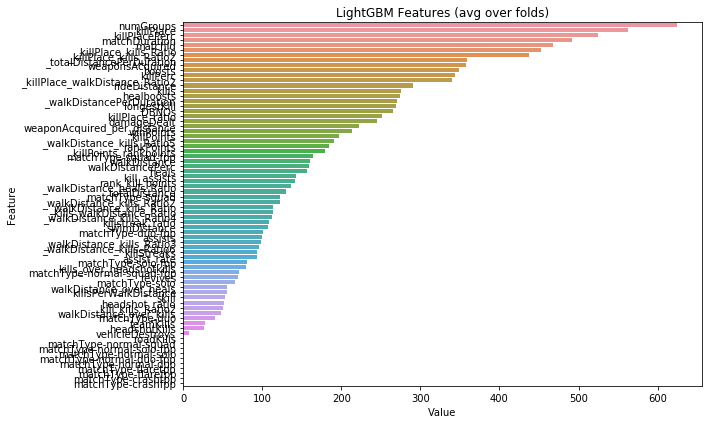

In [48]:
from lightgbm import LGBMRegressor
lgb_params1 = {}
lgb_params1["learning_rate"] = 0.1
lgb_params1["n_estimators"] = 400
lgb_params1["max_bin"] = 10
lgb_params1["max_leaves"] =30
lgb_params1["max_depth"] =-1
lgb_params1["subsample"] =0.7
lgb_params1["lambda_1"] = 5
lgb_params1["lambda_2"] = 20
lgb_params1["subsample"] = 0.9
lgb_params1["subsample_freq"] = 12
lgb_params1["colsample_bytree"] = 0.6
lgb_params1["min_child_samples"] = 800
lgb_params1["seed"] = 1000
 
#モデルの定義
model1 = LGBMRegressor(**lgb_params1)
#学習
model1.fit(X_train, Y_train,
              eval_set=[(X_val,Y_val)],
              early_stopping_rounds=50,
              verbose=False)
Y_val_pred = model1.predict(X_val)
score = meanAbsoluteError(Y_val.values, Y_val_pred)
print("score : {} MAE".format(score))

feature_importance = pd.DataFrame(sorted(
    zip(model1.feature_importances_, X.columns))[::-1])
feature_importance.rename(columns={0:"Value", 1:"Feature"}, inplace=True)
plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_importance)
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [30]:
feature_importance

,Value,Feature
0,853,killPlace
1,664,numGroups
2,518,_killPlace_kills_Ratio
3,512,matchDuration
4,435,killPlacePerc
5,429,killPerc
6,373,_totalDistancePerDuration
7,357,boosts
8,337,_walkDistancePerDuration
9,298,healboosts
